Generate Fourier Coefficients from an image
-
The schedule is:
    1. Input image
    2. Grayscale image
    3. Binary (black and white) image
    4. Binary image with just the bigger block of adjacent black pixels
    5. Filtered image, with lines of just 1px stroke
    6. Curve
    7. Fourier's coefficients

<font size=5>Imports</font>

In [ ]:
# Imports
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

<font size=5>1. Input image</font>

In [ ]:
# file_path = 'images/_oneline.jpg'
# file_path = 'images/Caterpillar(raw).jpg'
# file_path = 'images/Caterpillar.jpg'
# file_path = 'images/froggo.jpg'
# file_path = 'images/froggohhh.jpg'
# file_path = 'images/micio.jpg'
# file_path = 'images/oneline.jpg'
file_path = 'images/oneline2.jpg'
# file_path = 'images/raccoon-one-continuous-line-drawing-funny-animal-mascot-concept-national-conservation-park-icon-isolated-white-background-202528499.jpg'
# file_path = 'images/raccooooooon.jpg'

<font size=5>2. Grayscale image</font>

In [ ]:
# Image conversion from RGB to Grayscale
def load_grayscale(path):
    image = cv2.imread(path)
    return cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)

In [ ]:
image_grayscale = load_grayscale(file_path)
print(f'Image loaded! ({np.unique(image_grayscale).shape[0]} colors)')

Image loaded! (18 colors)


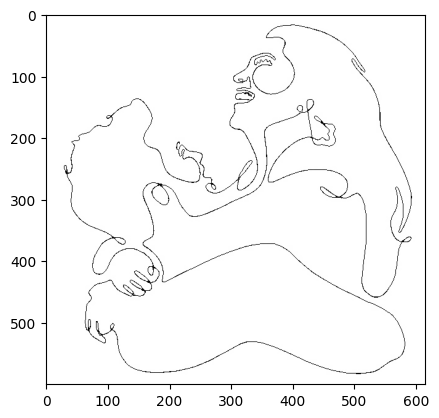

In [ ]:
plt.figure()
plt.imshow(image_grayscale)
plt.show()

<font size=5>3. Binary (black and white) image</font>

In [ ]:
# Image conversion from Grayscale to Binary, given a threshold
def grayscale_to_binary(img, threshold=-1, filter=0):
    img = img.copy()
    mask = img[:, :, 0]
    if threshold == -1:
        valids = np.where(mask < int((1 - filter) * 255))
        th = np.mean(mask[valids])
    else:
        th = threshold
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            img[r, c, :3] = 255 if mask[r, c] >= th else 0
    return img

In [ ]:
image_binary = grayscale_to_binary(image_grayscale)

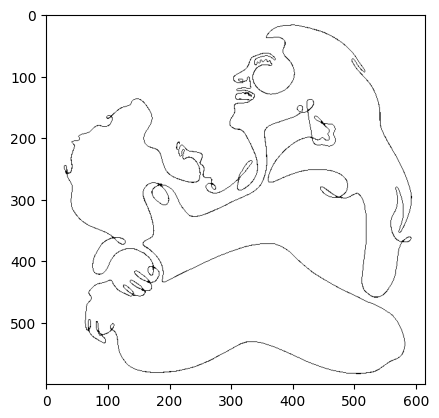

In [ ]:
plt.figure()
plt.imshow(image_binary)
plt.show()

<font size=5>4. Binary image with just the bigger block of adjacent black pixels</font>

In [ ]:
def find_cluster(map, pos):
    cluster = [pos]
    todo = [pos]
    map[pos[0], pos[1]] = 255
    while len(todo) > 0:
        p = todo.pop(0)
        map[p[0], p[1]] = 255
        for r in range(p[0] - 1, p[0] + 2):
            for c in range(p[1] - 1, p[1] + 2):
                if map[r, c] == 0:
                    map[r, c] = 255
                    cluster.append([r, c])
                    todo.append([r, c])
    return cluster


def denoise_image(img):
    img = img.copy()
    mask = img[:, :, 0].copy()
    clusters = []
    while True:
        zeros = np.argwhere(mask == 0)
        if len(zeros) == 0:
            break
        start = [zeros[0, 0], zeros[0, 1]]
        cluster = find_cluster(mask, start)
        clusters.append(cluster)
    best = -1
    best_score = 0
    for i in range(len(clusters)):
        if len(clusters[i]) > best_score:
            best = i
            best_score = len(clusters[i])
    for i in range(len(clusters)):
        if i != best:
            for elem in clusters[i]:
                img[elem[0], elem[1], :3] = 255
    return img, len(clusters) - 1

In [ ]:
image_denoised, removed_impurities = denoise_image(image_binary)
print(f'Removed {removed_impurities} impurities')

Removed 2 impurities


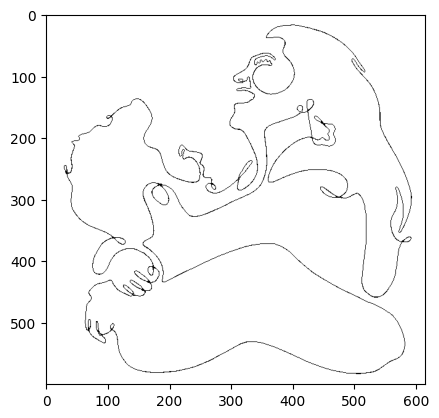

In [ ]:
plt.figure()
plt.imshow(image_denoised)
plt.show()

<font size=5>5. Filtered image, with lines of just 1px stroke</font>

In [ ]:
# TODO

<font size=5>6. Curve</font>

In [ ]:
def weight_ks(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    dist = np.sqrt(dx * dx + dy * dy)
    return 1 / (1 + dist)


def weight_ks_velocity(x1, y1, x2, y2, vx, vy):
    if x1 == x2 and y1 == y2:
        return 0
    dx = x2 - x1
    dy = y2 - y1
    norm = np.linalg.norm([dx, dy])
    vx2 = dx / norm
    vy2 = dy / norm
    return vx * vx2 + vy * vy2


def find_start_point(img):
    start_point = np.argwhere(img == 0)
    for p in start_point:
        # Searches for a point with two neighborhoods sharing the same axis, so that once onto
        # that point, the velocity will surely be the same
        if np.count_nonzero(img[p[0] - 1:p[0] + 2, p[1] - 1:p[1] + 2] == 0) == 3:
            if img[p[0] - 1, p[0] - 1] + img[p[0] + 1, p[0] + 1] == 0:
                return [p[1], p[0]]
            if img[p[0] - 1, p[0] + 1] + img[p[0] + 1, p[0] - 1] == 0:
                return [p[1], p[0]]
            if img[p[0], p[0] - 1] + img[p[0], p[0] + 1] == 0:
                return [p[1], p[0]]
            if img[p[0] - 1, p[0]] + img[p[0] + 1, p[0]] == 0:
                return [p[1], p[0]]
    return [start_point[0, 1], start_point[0, 0]]


def find_start_velocity(img, x0, y0):
    # p1 = np.argwhere(img[y0 - 1:y0 + 2, x0 - 1:x0 + 2] == 0)[0]
    return [0, 0]


# Tries to generate a closed 2D-curve from a Binary Image
def image_to_curve(img, kernel_range=1):
    success = False
    curve_x = []
    curve_y = []

    # Preparing the image
    img = img[:, :, 0]
    w_img = img.shape[1]
    h_img = img.shape[0]
    tmp_img = np.ones(shape=(h_img + 2 * (kernel_range + 1), w_img + 2 * (kernel_range + 1)))
    tmp_img[1:h_img + 1, 1:w_img + 1] = img
    img = tmp_img
    w_img = img.shape[1]
    h_img = img.shape[0]

    # Creating matrix of velocities
    velocities_matrix = [[[] for _ in range(h_img)] for _ in range(w_img)]

    # Finding the starting point
    start_point = find_start_point(img)
    x, y = start_point[0], start_point[1]
    
    # Finding the starting velocity
    vx, vy = find_start_velocity(img, x, y)

    # here the algorith starts
    while True:
        # looking for best next point near the current, using as metric dot product between velocity vectors
        # v0 dot v1. the best value will tell which point will be the next
        best_score = -1
        next_x = x
        next_y = y
        next_vx = 0
        next_vy = 0
        for r in range(y - 1, y + 2):  # -1 0 +1 (+1 to include the end)
            for c in range(x - 1, x + 2):
                if img[r, c] != 0:
                    continue
                if r == y and c == x:
                    continue
                # Evaluating the Kernel Score (KS) of the current point
                ks = 1
                if kernel_range > 0:
                    ks = 0
                    for kr in range(r - kernel_range, r + kernel_range + 2):
                        for kc in range(c - kernel_range, c + kernel_range + 2):
                            if img[kr, kc] == 0:
                                ks += weight_ks(r, c, kc, kr)
                                # ks += weight_ks_velocity(x, y, kc, kr, vx, vy)
                    ks = np.abs(ks)
                # Computing the dot product with the point associated to a KS
                dx = c - x
                dy = r - y
                norm = np.linalg.norm([dx, dy])
                vx2 = dx / norm
                vy2 = dy / norm
                dot = vx * vx2 + vy * vy2
                score = ks * dot
                # if score > best_score:
                if score > best_score or score == best_score and len(velocities_matrix[x][y]) == 0:
                    best_score = score
                    next_x = c
                    next_y = r
                    next_vx = vx2
                    next_vy = vy2
        # If the best point is the starting point of the curve, then the curve is built
        if next_x == start_point[0] and next_y == start_point[1]:
            print('Success!')
            success = True
            break
        # If the best point is the current one, it means that the curve is not closed, and so it returns
        # if x == next_x and y == next_y:
        #     print(x, y, 'Warning: block')
        #     break
        # If a loop is detected, it stops
        if [vx, vy] in velocities_matrix[x][y]:
            print(x, y, 'Warning: loop', velocities_matrix[x][y])
            break
        # Saving the current point
        velocities_matrix[x][y].append([vx, vy])
        curve_x.append(x)
        curve_y.append(y)
        # Updating the current values
        x = next_x
        y = next_y
        vx = next_vx
        vy = next_vy

    return curve_x, curve_y, success, start_point, [x, y], [vx, vy]

In [ ]:
# Getting a one-line curve
curve_x, curve_y, success, start_point, stop_point, stop_velocity = image_to_curve(image_denoised, kernel_range=0)

Success!


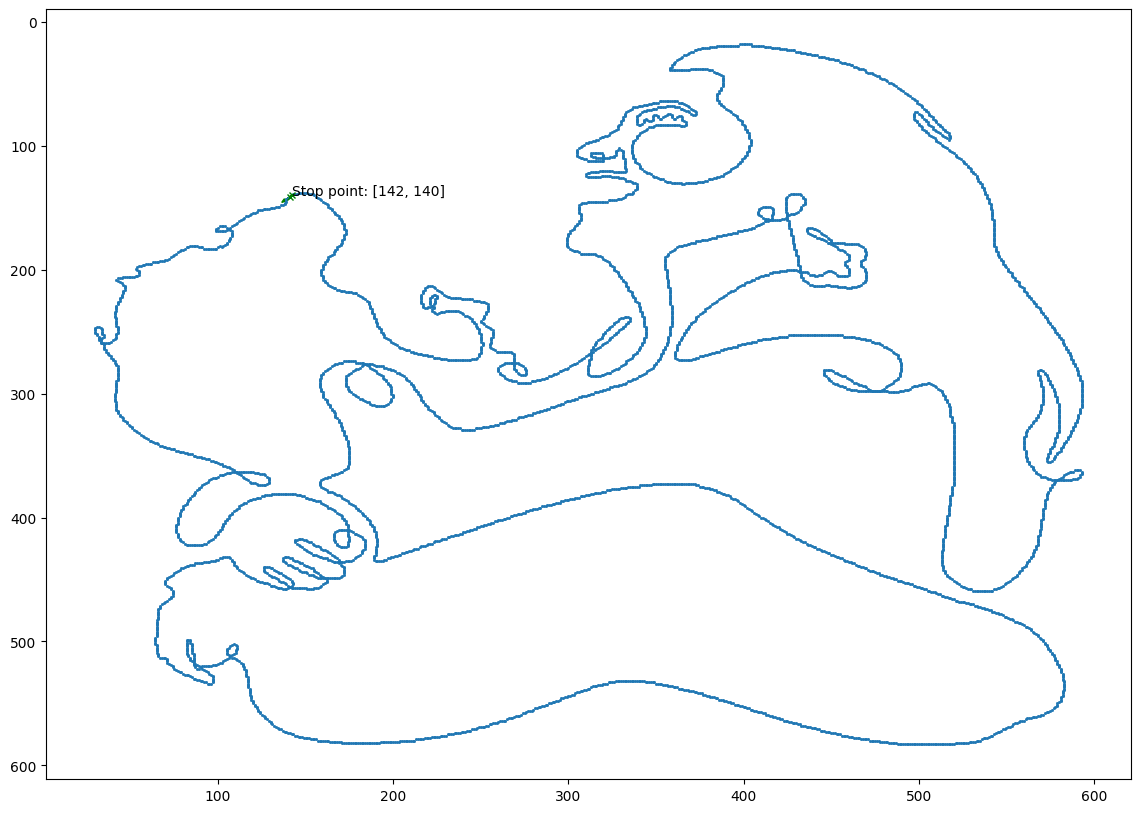

In [ ]:
# Showing curve
plt.figure(figsize=(14, 10))
plt.gca().invert_yaxis()
plt.plot(curve_x, curve_y, 's', markersize=1)
plt.plot(start_point[0], start_point[1], 'gx', markersize=5)
plt.plot(stop_point[0], stop_point[1], 'gx' if success else 'rx', markersize=5)
plt.arrow(stop_point[0], stop_point[1], 5 * stop_velocity[0], 5 * stop_velocity[1],
          color='green' if success else 'red',
          head_width=2)
plt.text(stop_point[0], stop_point[1], f'Stop point: {stop_point}')
plt.savefig('./outcurve.png')
plt.show()

<font size=5>7. Fourier's coefficients</font>

In [ ]:
# Generates the Fourier Coefficients from a 2D-curve
def ftransform(x, y, n_coeffs: int, scale_factor: float = 1):
    assert len(x) == len(y)
    n_elems = len(x)
    t = np.linspace(0, 1, n_elems + 1)[:n_elems]
    dt = t[1] - t[0]
    fc = [scale_factor * complex(x[i], y[i]) for i in range(n_elems)]
    out = np.empty(shape=(2 * n_coeffs + 1, 3))
    for n in range(-n_coeffs, n_coeffs + 1):
        e = np.exp(-2j * np.pi * n * t)
        Cn = dt * np.sum(np.multiply(fc, e))
        i = 2 * abs(n) - (1 if n > 0 else 0)
        out[i] = [n, np.angle(Cn), np.abs(Cn)]
    return out

In [ ]:
# Computing fourier coefficients
n_coefficients = 200
coeffs = ftransform(curve_x, curve_y, n_coeffs=n_coefficients, scale_factor=1)

# Printing coefficients on the output file
stdout_bak = sys.stdout
with open('out.txt', 'w') as file:
    sys.stdout = file
    print(f'{n_coefficients * 2}')
    for i in range(1, len(coeffs)):
        print(f'{coeffs[i, 1]} {coeffs[i, 0]} {coeffs[i, 2]}')
sys.stdout = stdout_bak